<a href="https://colab.research.google.com/github/RaviPatel021/LLM_MachineLearning/blob/main/LLM_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Amazon_reviews_plus_LLM.csv")

In [ ]:
df = df[['reviewText', 'llm']]

In [ ]:
train_true = df[198502:]
train_false = df[:198502]

In [ ]:
false_sample = train_false.sample(frac=0.03, replace=False)

df = false_sample
df = df.append(train_true)

In [ ]:
df['reviewText']=df['reviewText'].astype(str)
df['llm'] = df['llm'].astype(int)

# TensorFlow Hub

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
df = df.sample(frac = 1)

In [ ]:
val = df[:2000]
df = df[2000:]

In [ ]:
train_history = model.fit(
    df['reviewText'], df['llm'],
    validation_split=0.1,
    epochs=10,
    batch_size=512
)

Epoch 1/10
17/17 [==============================] - 31s 2s/step - loss: 0.6567 - accuracy: 0.5145 - val_loss: 0.6067 - val_accuracy: 0.5373
Epoch 2/10
17/17 [==============================] - 25s 1s/step - loss: 0.5596 - accuracy: 0.5653 - val_loss: 0.4992 - val_accuracy: 0.7087
Epoch 3/10
17/17 [==============================] - 25s 1s/step - loss: 0.4359 - accuracy: 0.7709 - val_loss: 0.3719 - val_accuracy: 0.8601
Epoch 4/10
17/17 [==============================] - 26s 1s/step - loss: 0.3131 - accuracy: 0.8954 - val_loss: 0.2659 - val_accuracy: 0.9075
Epoch 5/10
17/17 [==============================] - 28s 2s/step - loss: 0.2127 - accuracy: 0.9318 - val_loss: 0.1937 - val_accuracy: 0.9338
Epoch 6/10
17/17 [==============================] - 27s 2s/step - loss: 0.1478 - accuracy: 0.9541 - val_loss: 0.1520 - val_accuracy: 0.9506
Epoch 7/10
17/17 [==============================] - 26s 2s/step - loss: 0.1111 - accuracy: 0.9654 - val_loss: 0.1336 - val_accuracy: 0.9558
Epoch 8/10
17/17 [==

In [ ]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.11237835>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9610936>}

In [ ]:
y_preds = model.predict(val['reviewText'])

63/63 [==============================] - 12s 188ms/step


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val['llm'], y_preds)

0.9940540047820385

In [ ]:
print(y_preds)

[[ 5.199019  ]
 [-4.099808  ]
 [-5.4317    ]
 ...
 [-0.48378068]
 [-5.268002  ]
 [-5.2062697 ]]


In [ ]:
for i in range(len(y_preds)):
  if y_preds[i]>0:
    y_preds[i]=1
  else:
    y_preds[i]=0

y_preds =y_preds.astype(int)


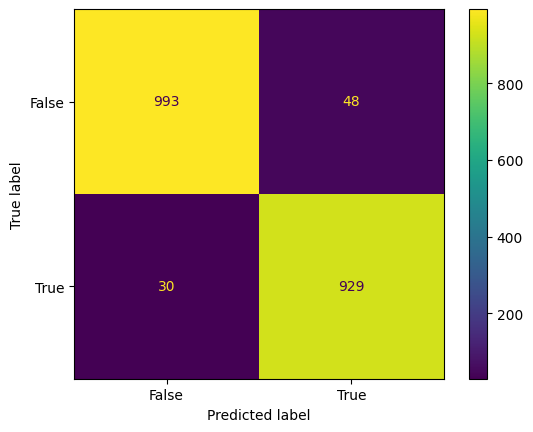

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(val['llm'], y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# Classify text with BERT

In [ ]:
!pip install tensorflow_text

In [ ]:
!pip install tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

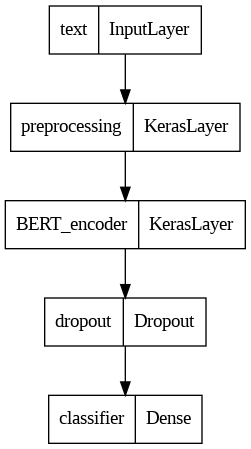

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df['reviewText'].values, tf.string),
            tf.cast(df['llm'].values, tf.int32)
        )
    )
)

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = classifier_model.fit(
    df['reviewText'], df['llm'],
    validation_split=0.1,
    epochs=epochs,
)

Epoch 1/5
268/268 [==============================] - 2481s 9s/step - loss: 0.6330 - binary_accuracy: 0.6424 - val_loss: 0.4145 - val_binary_accuracy: 0.8791
Epoch 2/5
268/268 [==============================] - 2650s 10s/step - loss: 0.2832 - binary_accuracy: 0.8863 - val_loss: 0.2437 - val_binary_accuracy: 0.9201
Epoch 3/5
268/268 [==============================] - 2635s 10s/step - loss: 0.1534 - binary_accuracy: 0.9397 - val_loss: 0.1947 - val_binary_accuracy: 0.9380
Epoch 4/5
268/268 [==============================] - 2691s 10s/step - loss: 0.1143 - binary_accuracy: 0.9547 - val_loss: 0.1966 - val_binary_accuracy: 0.9422
Epoch 5/5
268/268 [==============================] - 2705s 10s/step - loss: 0.0868 - binary_accuracy: 0.9672 - val_loss: 0.1690 - val_binary_accuracy: 0.9485


In [ ]:
y_preds = classifier_model.predict(val['reviewText'])

63/63 [==============================] - 158s 3s/step


In [ ]:
for i in range(len(y_preds)):
  if y_preds[i]>0:
    y_preds[i]=1
  else:
    y_preds[i]=0

y_preds =y_preds.astype(int)

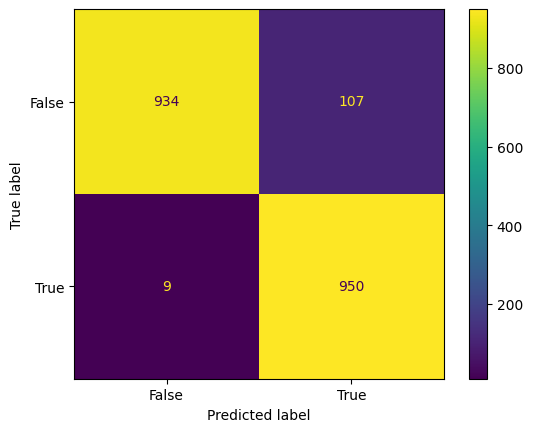

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(val['llm'], y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val['llm'], y_preds)

0.9439147206454049

# RNN

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df['reviewText'].values, tf.string),
            tf.cast(df['llm'].values, tf.int32)
        )
    )
)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, llm: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:50]


array(['', '[UNK]', 'i', 'and', 'the', 'it', 'a', 'to', 'this', 'my',
       'is', 'for', 'of', 'that', 'hair', 'with', 'have', 'but', 'its',
       'in', 'product', 'so', 'on', 'not', 'was', 'skin', 'great',
       'really', 'im', 'use', 'you', 'very', 'like', 'using', 'as',
       'love', 'are', 'been', 'would', 'recommend', 'ive', 'or', 'all',
       'be', 'good', 'has', 'they', 'me', 'just', 'out'], dtype='<U13')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    df['reviewText'], df['llm'],
    validation_split=0.1,
    epochs=10,
    validation_steps=30
)

Epoch 1/10
268/268 [==============================] - 182s 681ms/step - loss: 0.2150 - accuracy: 0.9198 - val_loss: 0.2043 - val_accuracy: 0.9253
Epoch 2/10
268/268 [==============================] - 180s 674ms/step - loss: 0.1620 - accuracy: 0.9427 - val_loss: 0.1628 - val_accuracy: 0.9348
Epoch 3/10
268/268 [==============================] - 154s 570ms/step - loss: 0.1299 - accuracy: 0.9522 - val_loss: 0.1436 - val_accuracy: 0.9317
Epoch 4/10
268/268 [==============================] - 151s 565ms/step - loss: 0.1102 - accuracy: 0.9592 - val_loss: 0.1505 - val_accuracy: 0.9380
Epoch 5/10
268/268 [==============================] - 143s 533ms/step - loss: 0.0964 - accuracy: 0.9645 - val_loss: 0.1573 - val_accuracy: 0.9422
Epoch 6/10
268/268 [==============================] - 141s 525ms/step - loss: 0.0830 - accuracy: 0.9702 - val_loss: 0.1686 - val_accuracy: 0.9422
Epoch 7/10
268/268 [==============================] - 146s 546ms/step - loss: 0.0747 - accuracy: 0.9739 - val_loss: 0.1317 -

In [ ]:
y_preds = model.predict(val['reviewText'])

63/63 [==============================] - 8s 85ms/step


In [ ]:
for i in range(len(y_preds)):
  if y_preds[i]>0:
    y_preds[i]=1
  else:
    y_preds[i]=0

y_preds =y_preds.astype(int)

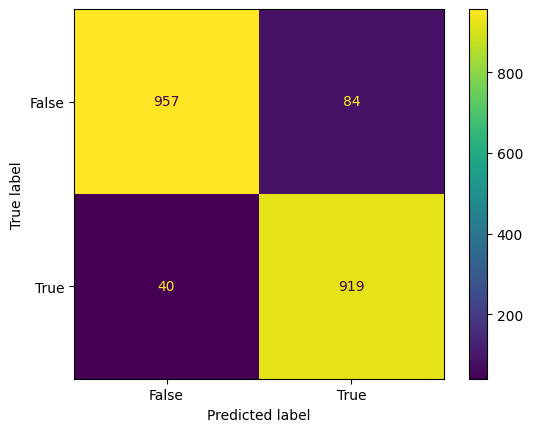

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(val['llm'], y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val['llm'], y_preds)

0.9387991213229439